## Request Dask Cluster for parallel processing of the data

This notebook server does not have enough cores to efficiently work with the data, so lets get a dask cluster set up first:

In [16]:
from dask_gateway import GatewayCluster
from distributed import Client

cluster = GatewayCluster()
cluster.scale(30)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1481a769f2ee4199a11cc939ab1e8763/status,


# Demo for AMS22

This was developed and tested on the Google Pangeo Deployment (more infos [here](https://pangeo.io/cloud.html#)).

In [17]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 15, 8
%config InlineBackend.figure_format = 'retina'

## Load and clean the data

For this example we use a catalog of CMIP6 zarr files, maintained by the Pangeo Project, and hosted publicly on GCS. For more info on the pangeo CMIP6 data click [here](https://pangeo-data.github.io/pangeo-cmip6-cloud/).

This example uses the custom intake-esm catalog provided, but all functions shown here can be applied to an xarray dataset directly.

In [18]:
import intake
import xarray as xr
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

We are only using a few selected models (and members) for the sake of time. But there are a lot more. Feel free to change the cell below and experiment.

In [19]:
# This function is the 'all-in-one' cleaning component of cmip6_preprocessing
from cmip6_preprocessing.preprocessing import combined_preprocessing

selected_models = [
    "IPSL-CM6A-LR",
    "ACCESS-ESM1-5",
    "GFDL-ESM4",
    "CESM2",
    "MPI-ESM1-2-LR",
    "TaiESM1",
    "CanESM5",
    "MIROC-ES2L",
    "EC-Earth3",
    "CMCC-ESM2",
]

query = dict(
    experiment_id=["historical", "ssp585"],
    source_id=selected_models,
    grid_label='gn',
)

kwargs = dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
    preprocess=combined_preprocessing, # This is the only modification needed
    aggregate=False,
    storage_options={'anon':True},
)

# load two dataset dictionaries: One for the surface temperature and another
# for the horizontal grid area

dset_dict = col.search(
    variable_id="tos",
    member_id=["r4i1p1f1", "r3i1p1f1", "r5i1p1f1","r2i1p1f1","r1i1p1f1"],
    table_id="Omon",
    **query
).to_dataset_dict(**kwargs)

metric_dict = col.search(
    variable_id="areacello",
    **query
).to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


### You dont need intake-esm
You can easily open any of the zarr stores with xarray (and then apply cmip6_preprocessing tools on it in the same way).

In [15]:
zarr_store = col.df['zstore'].tolist()[0]
print(zarr_store)
ds = xr.open_zarr(zarr_store)
ds

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 804)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1948-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(804, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ps         (time, lat, lon) float32 dask.array<chunksize=(804, 192, 288), meta=np.ndarray>
Attributes: (12/47)
    CDI:                     Climate Data Interface version 1.8.0 (http://mpi...
    CDO:                     Climate Data Operators version 1.8.0 (http://mpi...
    Conventions:             CF-1.7 CMIP-6.0
    activity_id:             HighResMIP
    cmor_version:            3.2.3
    creation_date:           2017-07-02T15:45:01Z
    ...                      ...
    tracking_id:             hdl:21.14100/bcc2c7c0-0ea9-4041-bdeb-d61d325a2cbb
    variable_id:             ps
    variant_label:           r1i1p1f1
    status:                  2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/bcc2c7c0-0ea9-4041-bdeb-d61d325a2cbb
    version_id:              v20170706

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.9/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1129)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

## Postprocessing - Combining datasets for final analysis

Now we will add the metrics (horizontal cell area) and concatenate the members of each model into a dataset with an additional `member_id` dimension. 

In [20]:
from cmip6_preprocessing.postprocessing import match_metrics, concat_members

# cut runs that are running past 2100 (can lead to dask chunking issues)
dset_dict_cut = {k:ds.sel(time=slice(None,'2100')) for k,ds in dset_dict.items()}
#combine with matching metrics 
# (see https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html#Handling-grid-metrics-in-CMIP6)
dset_dict_w_metrics = match_metrics(dset_dict_cut, metric_dict, ['areacello'])
# concatenate members for each source_id and experiment_id 
# (see https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html#Postprocessing)
dset_dict_combined = concat_members(dset_dict_w_metrics)

In [6]:
dset_dict_combined['CESM2.gn.historical.Omon']

<xarray.Dataset>
Dimensions:        (y: 384, x: 320, vertex: 4, time: 1980, bnds: 2, member_id: 5)
Coordinates: (12/13)
    lat            (y, x) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    lat_verticies  (y, x, vertex) float32 -79.49 -78.95 -78.95 ... 72.41 71.96
    lon            (y, x) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    lon_verticies  (y, x, vertex) float32 320.0 320.0 321.1 ... 320.0 320.0
  * y              (y) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * x              (x) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
    ...             ...
    time_bounds    (time, bnds) object 1850-01-01 02:00:00.000003 ... 2015-01...
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
    lon_bounds     (bnds, y, x) float32 320.0 321.1 322.2 ... 319.1 319.6 320.0
    lat_bounds     (bnds, y, x) float32 -79.49 -79.49 -79.49 ... 72.42 72.41
    areacello      (y, x) float32 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Dimensions without coordinates: member_id
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 403, 384, 320), meta=np.ndarray>
Attributes: (12/40)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           CMIP
    branch_method:         standard
    branch_time_in_child:  674885.0
    contact:               cesm_cmip6@ucar.edu
    data_specs_version:    01.00.29
    ...                    ...
    table_id:              Omon
    variable_id:           tos
    variant_info:          CMIP6 20th century experiments (1850-2014) with CA...
    status:                2019-10-25;created;by nhn2@columbia.edu
    version_id:            v20190308
    intake_esm_varname:    None

CPU times: user 4.34 s, sys: 91.7 ms, total: 4.43 s
Wall time: 1min 7s


Text(0, 0.5, 'Global Average Sea Surface Temperature')

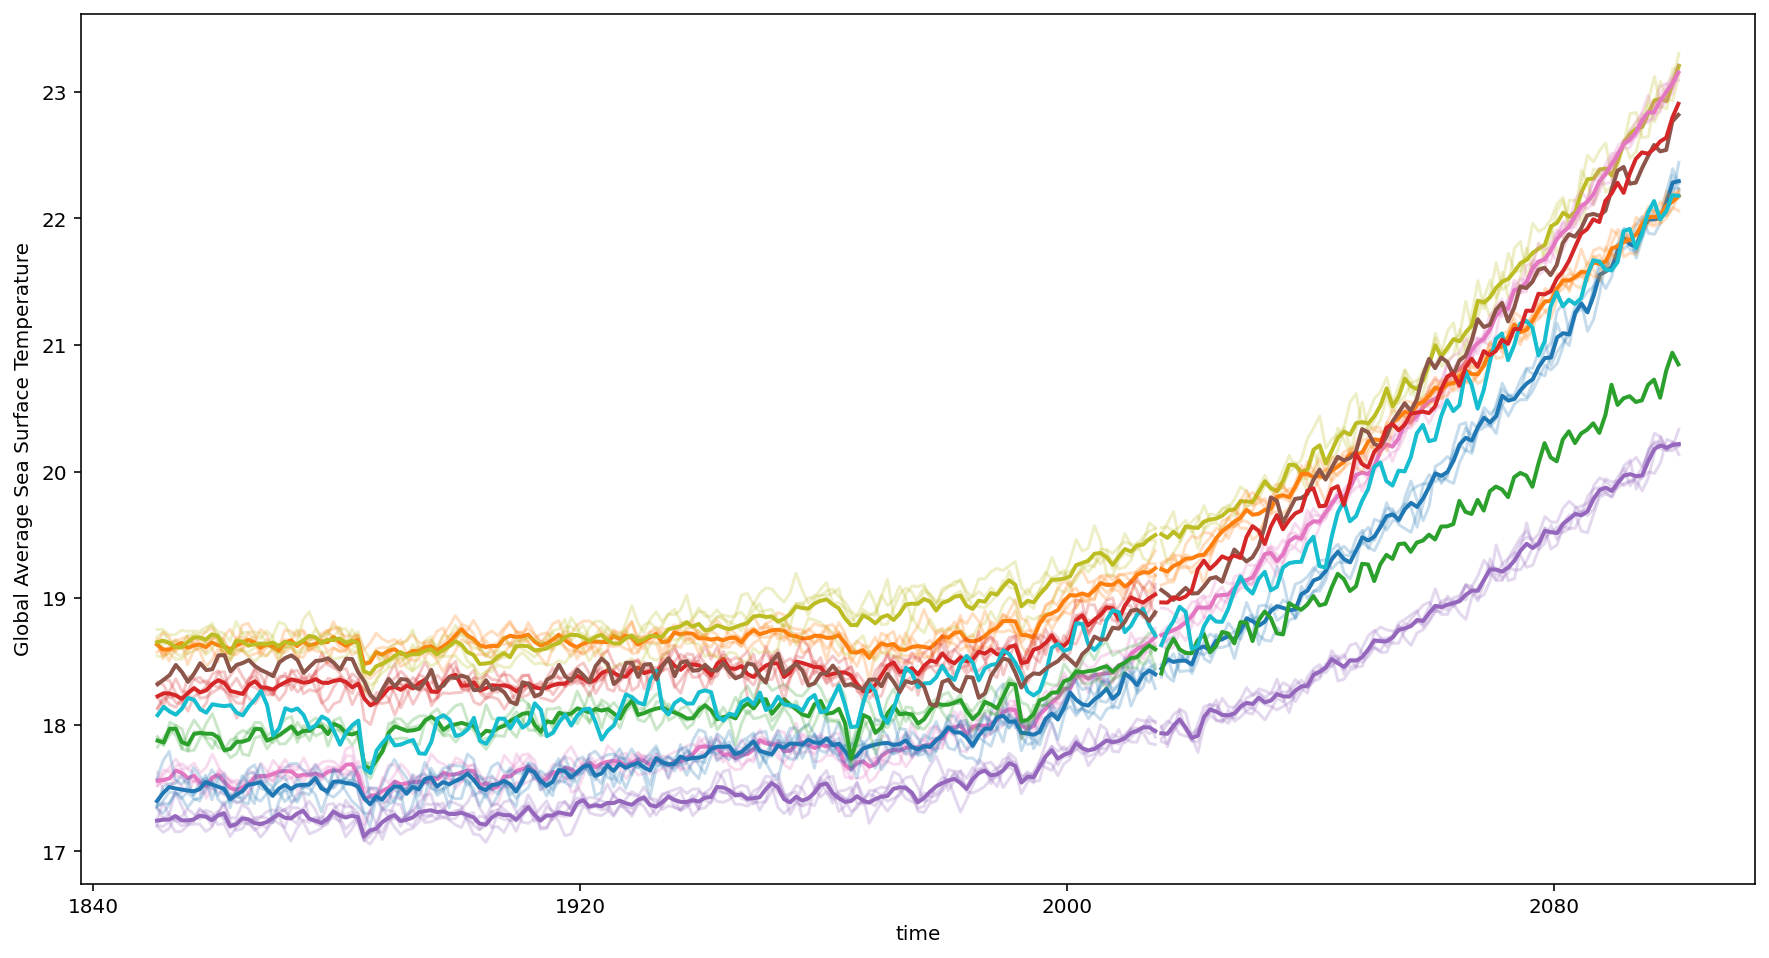

In [21]:
%%time
import matplotlib.pyplot as plt

color_dict = {k:f"C{ki}" for ki, k in enumerate(selected_models)}

plt.figure()
for ni, (name, ds) in enumerate(dset_dict_combined.items()):
    
    # Weighted average of surface ocean temperatures
    sst = ds.tos.weighted(ds.areacello.fillna(0)).mean(['x','y'])
    
    # annual averages
    sst = sst.coarsen(time=12).mean()
    
    ### Plotting ###
    color = color_dict[ds.source_id]
    # plot single members
    sst.plot(
        hue='member_id',
        color=color,
        add_legend=False,
        alpha=0.25
    )
    # plot member average
    sst.mean('member_id').plot(
        linewidth=2,
        color=color,
        add_legend=False,
        label=name
    )
    
plt.ylabel('Global Average Sea Surface Temperature')

## How much data did we processed just now?

In [22]:
total_size = []
for ni, (name, ds) in enumerate(dset_dict_combined.items()):
    sst_size = ds.tos.nbytes
    area_size = ds.areacello.nbytes
    total_size.append(sst_size+area_size)
print(f'We just crunched through {sum(total_size)/1e9}GB of data')

We just crunched through 47.313962112GB of data


This means that we were able to process around 40+GB in a few minutes. Contrast that with the 'download and analyze' model:

>Assuming a fast internet connection with 20MB/s throughput, downloading this data alone would have taken 30+ minutes.